In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions,Session
import time

In [2]:
# Load saved credentials
service = QiskitRuntimeService()

In [3]:
def generate_graph(num_nodes, edge_prob=0.5):
    return nx.erdos_renyi_graph(num_nodes, edge_prob)

In [ ]:
# QUBO conversion and Hamiltonian construction
def create_qubo_hamiltonian(graph, num_colors):
    num_nodes = graph.number_of_nodes()
    Q = np.zeros((num_nodes * num_colors, num_nodes * num_colors))
    for i in range(num_nodes):
        for c in range(num_colors):
            Q[i * num_colors + c, i * num_colors + c] -= 1
            for cp in range(c + 1, num_colors):
                Q[i * num_colors + c, i * num_colors + cp] += 2
    for i, j in graph.edges():
        for c in range(num_colors):
            Q[i * num_colors + c, j * num_colors + c] += 1
    Q = 0.5 * (Q + Q.T)
    linear = np.diag(Q)
    quadratic = Q - np.diag(linear)
    h = {i: linear[i] for i in range(len(linear))}
    J = {(i, j): quadratic[i, j] for i in range(len(linear)) for j in range(i + 1, len(linear)) if quadratic[i, j] != 0}
    
    pauli_list = []
    for (i, j), weight in J.items():
        z_p = np.zeros(len(linear), dtype=bool)
        x_p = np.zeros(len(linear), dtype=bool)
        z_p[i] = True
        z_p[j] = True
        pauli_list.append((Pauli((z_p, x_p)), weight))
    for i, weight in h.items():
        z_p = np.zeros(len(linear), dtype=bool)
        x_p = np.zeros(len(linear), dtype=bool)
        z_p[i] = True
        pauli_list.append((Pauli((z_p, x_p)), weight))
    hamiltonian = sum([SparsePauliOp.from_list([(pauli.to_label(), weight)]) for pauli, weight in pauli_list])
    
    return hamiltonian

In [5]:
# Callback to count evaluations and iterations
evaluation_count = 0
iteration_count = 0

def optimizer_callback(eval_count):
    global evaluation_count, iteration_count
    evaluation_count = eval_count
    iteration_count += 1

In [6]:
from collections import defaultdict

qaoa_total_sample_time_per_node = defaultdict(float)


In [7]:
# Callback to count evaluations and iterations
evaluation_count = 0
iteration_count = 0
qaoa_exec_time = 0
qaoa_times1=[]
iteration_times =[]
simulation_time = 0
optimiser_result = []
def optimizer_callback(eval_count,paramters,mean,metadata):
    global evaluation_count, iteration_count,qaoa_exec_time,simulation_time
    iteration_times.append((metadata['simulator_metadata']['sample_measure_time']))
    qaoa_exec_time+=(metadata['simulator_metadata']['sample_measure_time'])
    iteration_count += 1
    simulation_time+=(metadata['simulator_metadata']['time_taken'])
    # print(f"Metadata: {metadata}")

In [8]:
def is_valid_coloring(graph, coloring):
    """Return True if no adjacent vertices share the same color and all nodes are assigned valid colors."""
    for u, v in graph.edges():
        if coloring[u] == -1 or coloring[v] == -1:
            return False
        if coloring[u] == coloring[v]:
            return False
    return True


In [9]:
def decode_solution(result, num_colors):
    """Convert QAOA result to color assignments."""
    optimal_bitstring = max(result.eigenstate.items(), key=lambda x: x[1])[0]
    n_vertices = len(optimal_bitstring) // num_colors
    coloring = []
    
    for i in range(n_vertices):
        # Extract color assignment for vertex i
        color_bits = optimal_bitstring[i*num_colors : (i+1)*num_colors]
        color = color_bits.index('1')  # Find which color is assigned
        coloring.append(color)
    
    return coloring


In [46]:
def run_qaoa(graph,hamiltonian, p=3, max_iter=500, shots=1024):
    global evaluation_count, iteration_count,qaoa_exec_time,simulation_time
    evaluation_count = 0
    iteration_count = 0
    qaoa_exec_time = 0
    simulation_time = 0 

    optimizer = COBYLA(maxiter=max_iter, tol=1e-6, disp=True)
    
    base_sampler = Sampler(backend_options={"method": "automatic", "device": "CPU"},
        run_options={"shots": 1024, "seed": 42})
    
    qaoa = QAOA(optimizer=optimizer, reps=p, sampler=base_sampler, callback=optimizer_callback)
    
    # Measure the time for the QAOA execution
    result = qaoa.compute_minimum_eigenvalue(hamiltonian)
    # Extract optimal solution
    optimal_state_int = max(result.eigenstate.items(), key=lambda x: x[1])[0]
    num_qubits = hamiltonian.num_qubits
    
    # Convert integer to bitstring
    bitstring = bin(optimal_state_int)[2:].zfill(num_qubits)[::-1]
    optimal_solution = np.array([int(bit) for bit in bitstring])

    
    return qaoa_exec_time,evaluation_count, iteration_count, result, hamiltonian, qaoa,simulation_time,optimal_solution  # Create QAOA instance

In [11]:
def decode_binary_coloring(bitstring, num_vertices, num_colors):
    """
    Decodes a binary-encoded QAOA bitstring into color assignments for each vertex.
    Returns:
        coloring (list): List of assigned color indices for each vertex.
        valid (bool): True if all assignments are valid, False otherwise.
    """
    bits_per_node = int(np.ceil(np.log2(num_colors)))
    coloring = []
    valid = True

    for v in range(num_vertices):
        start = v * bits_per_node
        end = start + bits_per_node
        color_bits = bitstring[start:end]
        color_idx = int(color_bits, 2)
        if color_idx >= num_colors:
            coloring.append(-1)  # Invalid color assignment
            valid = False
        else:
            coloring.append(color_idx)
    return coloring, valid


In [ ]:
def run_qaoa_with_retry(graph, max_colors=10, p=3, max_iter=500, shots=1024):
    num_vertices = len(graph.nodes)
    iter = 0
    for num_colors in range(2, max_colors + 1):
        # Create Hamiltonian with current color count
        hamiltonian = create_qubo_hamiltonian(graph, num_colors)
        
        # Run QAOA
        qaoa_time, eval_count, iter_count, result, hamiltonian, qaoa, sim_time, optimal_result = run_qaoa(
            graph,hamiltonian, p, max_iter, shots
        )
        
        # Get the most probable measurement bitstring (as string, little-endian)
        optimal_state_int = max(result.eigenstate.items(), key=lambda x: x[1])[0]
        bits_per_node = int(np.ceil(np.log2(num_colors)))
        total_bits = num_vertices * bits_per_node
        bitstring = bin(optimal_state_int)[2:].zfill(total_bits)[::-1]
        print(f"bitsting for num node {num_vertices} is {bitstring}")
        
        # Decode coloring and check validity
        coloring, valid = decode_binary_coloring(bitstring, num_vertices, num_colors)
        
        # Check for graph coloring conflicts and invalid assignments
        if valid and is_valid_coloring(graph, coloring):
            print(iter)
            return num_colors, coloring, result, iter
        else:
            iter+=1
        
        # Optionally: print diagnostic info
        # print(f"Attempt with {num_colors} colors failed. Coloring: {coloring}, Valid: {valid}")
    
    raise ValueError(f"No valid coloring found with ≤ {max_colors} colors")


In [37]:
def dsatur_coloring(graph):
    coloring = {}
    saturation_degrees = {node: 0 for node in graph.nodes()}
    available_colors = [True] * len(graph.nodes())
    iterations = 0
    while len(coloring) < len(graph.nodes()):
        iterations += 1
        uncolored_nodes = [node for node in graph.nodes() if node not in coloring]
        max_saturation = -1
        selected_node = None
        for node in uncolored_nodes:
            if saturation_degrees[node] > max_saturation:
                max_saturation = saturation_degrees[node]
                selected_node = node
            elif saturation_degrees[node] == max_saturation:
                if selected_node is None or graph.degree[node] > graph.degree[selected_node]:
                    selected_node = node
        neighbor_colors = {coloring[neighbor] for neighbor in graph.neighbors(selected_node) if neighbor in coloring}
        for color in range(len(available_colors)):
            if color not in neighbor_colors:
                coloring[selected_node] = color
                break
        for neighbor in graph.neighbors(selected_node):
            if neighbor not in coloring:
                saturation_degrees[neighbor] += 1
    return coloring, iterations

In [14]:
def run_dsatur(graph):
    start_time = time.time()
    _, classical_iter = dsatur_coloring(graph)
    classical_time = time.time() - start_time
    return classical_time, classical_iter

In [15]:
# Initialize lists to store the results
num_nodes_list = []
qaoa_times = []
qaoa_iterations = []
qaoa_evaluations = []
classical_times = []
classical_iterations = []
results = []
hamiltonians = []
simulation_times = []

In [16]:
import logging

# Configure logging
logging.basicConfig(filename='graph_coloring_results.log', level=logging.INFO,
                    format='%(asctime)s - %(message)s', filemode='w')  # 'w' to overwrite each time

# Run experiments and log
# for num_nodes in range(3, 10): 
#     G = generate_graph(num_nodes)
#     pos = nx.spring_layout(G)
#     qaoa_time, qaoa_eval, qaoa_iter = run_qaoa(G)
#     # classical_time, classical_iter = run_dsatur(G)
    
#     # Collect results
#     num_nodes_list.append(num_nodes)
#     qaoa_iterations.append(qaoa_iter)
#     qaoa_evaluations.append(qaoa_eval)
    # classical_times.append(classical_time)
    # classical_iterations.append(classical_iter)

    # Generate and run algorithms on graphs with increasing sizes
for num_nodes in range(3, 6): 
    G = generate_graph(num_nodes)
    qaoa_exec_time, qaoa_eval, qaoa_iter, result, hamiltonian, qaoa,simulation_time,optimal_solution = run_qaoa(G)
    
    # Collect results
    num_nodes_list.append(num_nodes)
    qaoa_times.append(qaoa_exec_time)
    qaoa_iterations.append(qaoa_iter)
    qaoa_evaluations.append(qaoa_eval)
    results.append(result)
    hamiltonians.append(hamiltonian)
    simulation_times.append(simulation_time)
    
    # Log results
    logging.info(f"Nodes: {num_nodes}  "
                 f"QAOA sim Time - Time: {qaoa_exec_time}seconds, Iter: {qaoa_iterations}  "
                 f"QAOA results: {result}")
    print(f"optimal_solution is {optimal_solution} for number of nodes {num_nodes}")




optimal_solution is [0 1 1 0 0 0 1 0 0] for number of nodes 3
optimal_solution is [0 0 1 1 0 0 0 0 1 0 1 0] for number of nodes 4
optimal_solution is [0 1 0 1 0 0 1 0 1 0 0 1 0 1 0] for number of nodes 5


In [17]:
# # Plot the results
# plt.figure(figsize=(14, 7))

# # Plot execution times
# plt.subplot(1, 3, 1)
# plt.plot(num_nodes_list, qaoa_times, label='Quantum (QAOA)', marker='o')
# # plt.plot(num_nodes_list, classical_times, label='Classical (DSATUR)', marker='o')
# plt.xlabel('Number of Nodes')
# plt.ylabel('Execution Time (seconds)')
# plt.title('Execution Time vs. Number of Nodes')
# plt.legend()

# # Plot number of iterations
# plt.subplot(1, 3, 2)
# plt.plot(num_nodes_list, qaoa_iterations, label='Quantum (QAOA)', marker='o')
# plt.plot(num_nodes_list, classical_iterations, label='Classical (DSATUR)', marker='o')
# plt.xlabel('Number of Nodes')
# plt.ylabel('Number of Iterations')
# plt.title('Number of Iterations vs. Number of Nodes')
# plt.legend()

# # Plot evaluation counts
# plt.subplot(1, 3, 3)
# plt.plot(num_nodes_list, qaoa_evaluations, label='Quantum (QAOA)', marker='o')
# plt.xlabel('Number of Nodes')
# plt.ylabel('Number of Evaluations')
# plt.title('Number of Evaluations vs. Number of Nodes')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [18]:
import time
import matplotlib.pyplot as plt
import networkx as nx

def plot_coloring(graph, coloring, num_colors):
    pos = nx.spring_layout(graph)
    # Use the modern colormap API for matplotlib
    cmap = plt.get_cmap('tab20', num_colors)
    node_colors = [cmap(color) if color != -1 else (0.8, 0.8, 0.8) for color in coloring]  # Gray for invalid
    nx.draw(graph, pos, with_labels=True, node_color=node_colors, node_size=500, font_color='white')
    plt.title(f'Graph Coloring with {num_colors} colors')
    plt.show()

In [19]:
def remap_colors(coloring):
    """Remap color indices to contiguous integers starting from 0."""
    unique_colors = sorted(set(coloring) - {-1})
    color_map = {color: idx for idx, color in enumerate(unique_colors)}
    remapped = [color_map[c] if c != -1 else -1 for c in coloring]
    return remapped, len(unique_colors)

In [20]:
def plot_coloring(graph, coloring, num_colors):
    import networkx as nx
    pos = nx.spring_layout(graph)
    cmap = plt.get_cmap('tab20', num_colors)
    node_colors = [cmap(color) if color != -1 else (0.8, 0.8, 0.8) for color in coloring]
    nx.draw(graph, pos, with_labels=True, node_color=node_colors, node_size=500, font_color='white')
    plt.title(f'Graph Coloring with {num_colors} colors')
    plt.show()

In [21]:
import networkx as nx
from collections import deque

def edge_bfs_depth(graph, edge):
    """Compute BFS depth starting from an edge (as a tuple of nodes)."""
    visited_edges = set()
    queue = deque([(edge, 0)])
    max_depth = 0
    while queue:
        (u, v), depth = queue.popleft()
        if (u, v) in visited_edges or (v, u) in visited_edges:
            continue
        visited_edges.add((u, v))
        max_depth = max(max_depth, depth)
        # Explore all edges adjacent to u or v
        for neighbor in set(graph.neighbors(u)).union(graph.neighbors(v)):
            if neighbor != u and neighbor != v:
                for node in (u, v):
                    if graph.has_edge(node, neighbor):
                        queue.append(((node, neighbor), depth + 1))
    return max_depth

In [22]:
def compute_c_depth(graph):
    """Compute the covering depth (c-depth) for the graph."""
    max_bfs_depth = 0
    for edge in graph.edges():
        depth = edge_bfs_depth(graph, edge)
        max_bfs_depth = max(max_bfs_depth, depth)
    return max_bfs_depth

In [ ]:
import json
def sweep_qaoa_p_levels(graph, max_colors=10, max_iter=500, shots=1024, p_max_extra=2):
    results = []

    logging.basicConfig(
    level=logging.INFO,
    filename='qaoa_results.log',
    filemode='a',  # append mode
    format='%(asctime)s - %(levelname)s - %(message)s'
    )

    # # Automatically determine p-level based on c-depth
    # c_depth = compute_c_depth(graph)
    # # Optionally, sweep a small range around c-depth
    # p_values = list(range(max(1, c_depth-1), c_depth + p_max_extra + 1))
    # print(f"Graph c-depth: {c_depth}. Sweeping p in {p_values}")

    # for p in p_values:
    p=3
    print(f"\nRunning QAOA with p={p}...")
    start_time = time.perf_counter()
    # try:
    num_colors, coloring, result,iter = run_qaoa_with_retry(
        graph, max_colors=max_colors, p=p, max_iter=max_iter, shots=shots
    )
    end_time = time.perf_counter()
    total_time = end_time - start_time

    remapped_coloring, actual_colors_used = remap_colors(coloring)

    print(f"Total time: {total_time:.4f} s")
    print(f"p-level: {p}")
    print(f"Number of colors allowed: {num_colors}")
    print(f"Number of colors actually used: {actual_colors_used}")
    print(f"Number of iterations: {iter}")
    print(f"Coloring (remapped): {remapped_coloring}")

    results.append({
        'p': p,
        'num_colors_allowed': num_colors,
        'num_colors_used': actual_colors_used,
        'coloring': remapped_coloring,
        'runtime': total_time,
        'result': result,
        'iterations': iter
    })

    # Plot the solution for each p
    plot_coloring(graph, remapped_coloring, actual_colors_used)

    # except ValueError as e:
    #     end_time = time.perf_counter()
    #     total_time = end_time - start_time
    #     print(f"Failed for p={p}: {e} (Time: {total_time:.4f} s)")
    #     results.append({
    #         'p': p,
    #         'error': str(e),
    #         'runtime': total_time
    #     })
    logging.info("QAOA run result: %s", json.dumps(results, default=str))
    return results



Running QAOA with p=3...
bitsting for num node 3 is 00110001
0
Total time: 1.6011 s
p-level: 3
Number of colors allowed: 2
Number of colors actually used: 2
Number of iterations: 0
Coloring (remapped): [0, 0, 1]


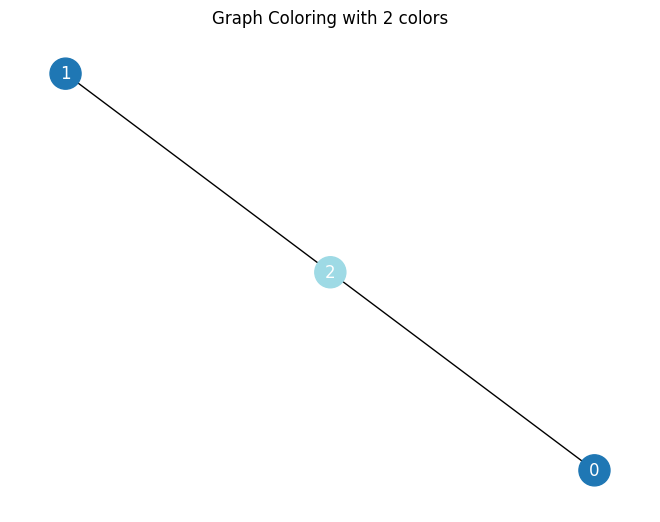


Running QAOA with p=3...
bitsting for num node 4 is 0010101
bitsting for num node 4 is 0100100101
1
Total time: 9.5869 s
p-level: 3
Number of colors allowed: 3
Number of colors actually used: 3
Number of iterations: 1
Coloring (remapped): [1, 0, 2, 1]


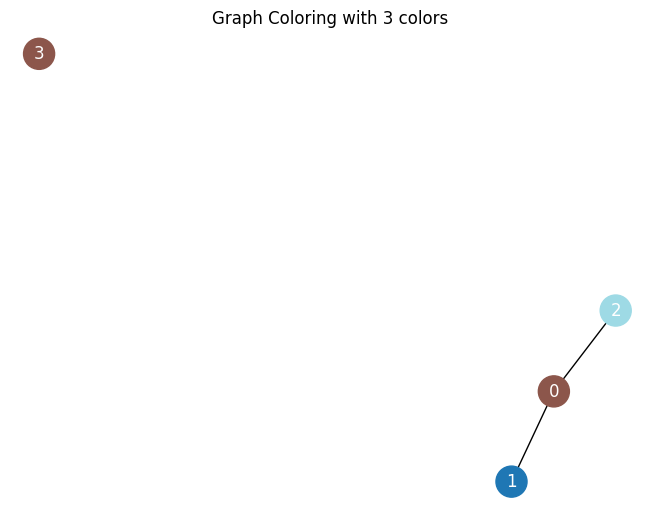


Running QAOA with p=3...
bitsting for num node 5 is 00100111011
bitsting for num node 5 is 10101110010111
bitsting for num node 5 is 111001100001
2
Total time: 20.3515 s
p-level: 3
Number of colors allowed: 4
Number of colors actually used: 4
Number of iterations: 2
Coloring (remapped): [3, 2, 1, 2, 0]


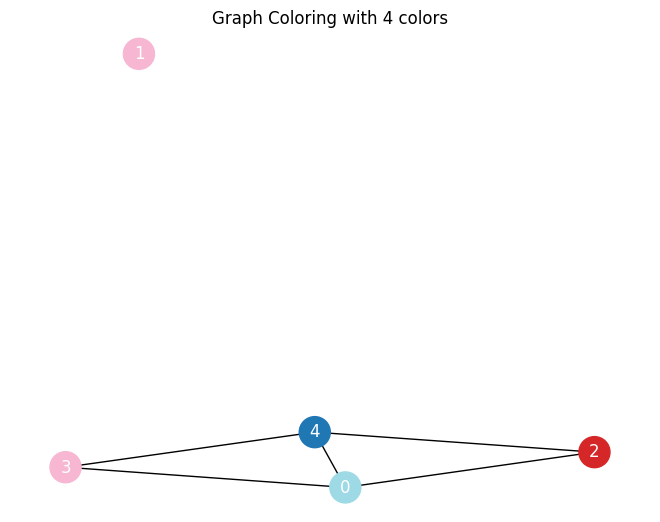


Running QAOA with p=3...
bitsting for num node 6 is 01010010000100101
bitsting for num node 6 is 011110010100111001
bitsting for num node 6 is 101011010001101
bitsting for num node 6 is 100000101010101001
bitsting for num node 6 is 001100100010100011
bitsting for num node 6 is 010010000110100111
bitsting for num node 6 is 001110011010101001
6
Total time: 77.9535 s
p-level: 3
Number of colors allowed: 8
Number of colors actually used: 5
Number of iterations: 6
Coloring (remapped): [0, 4, 2, 1, 3, 0]


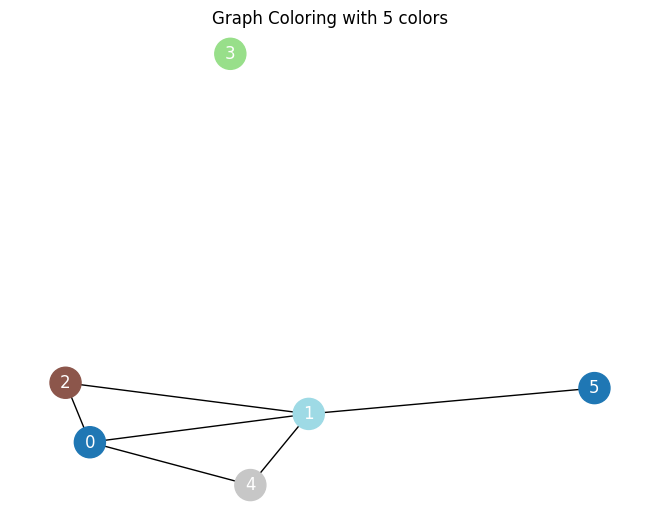


Running QAOA with p=3...
bitsting for num node 7 is 010001100100010100001
bitsting for num node 7 is 010111101001001110001
bitsting for num node 7 is 1101010111001011111
bitsting for num node 7 is 110011110111000100001
bitsting for num node 7 is 110100010110000000101
bitsting for num node 7 is 010100001000111011001
bitsting for num node 7 is 000100111010101000010


ValueError: No valid coloring found with ≤ 8 colors

In [45]:
for num_nodes in range(3, 8):
    G = generate_graph(num_nodes=num_nodes)
    results = sweep_qaoa_p_levels(G, max_colors=8, max_iter=500, shots=1024)
